# LSTM Time Series - Stock Price Prediction
## Part 3 - Model Training
In this notebook, we import the scaled dataset files, prepare them in a format suitable for LSTM modeling, and proceed to train the LSTM model.

> **INPUT**: Scaled dataset files for training, validation, and testing periods, as processed in the preceding phase. <br/>
> **OUTPUT**: Trained LSTM model and analysis of its performance.

### 1. INITIALIZATION

In [46]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

### 2. LOADING DATASETS

In [ ]:
# Prepare data file location and name
data_file_location = "/Users/nguyenconghung/Documents/PYTHON/lstm-stock-price-prediction/data/processed/"
data_file_name_train = "2303_stock_price_processed_train"
data_file_name_validate = "2303_stock_price_processed_validate"
data_file_name_test = "2303_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [48]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [49]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.000000  0.002422  0.001096  0.014909   0.014909  0.202348  2019-01-02
1  0.012090  0.004758  0.000269  0.000000   0.000000  0.254991  2019-01-03
2  0.007928  0.011707  0.006996  0.027351   0.027351  0.298130  2019-01-04
3  0.027184  0.013291  0.020776  0.026190   0.026190  0.279018  2019-01-07
4  0.029465  0.018586  0.023684  0.030138   0.030138  0.241988  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.687796  0.688344  0.695774  0.698226   0.698226  0.059318  2023-07-03
1  0.685223  0.711909  0.699352  0.718946   0.718946  0.092952  2023-07-05
2  0.690964  0.689648  0.691188  0.701930   0.701930  0.092117  2023-07-06
3  0.693438  0.695665  0.699654  0.694022   0.694022  0.119846  2023-07-07
4  0.675424  0.668791  0.664880  0.661292   0.661292  0.222041  2023-07-10
Testing Dataset:
       Open      High       Low     Close  Ad

### 3. DATA PREPROCESSING

The dataset has already undergone the primary preprocessing and transformation in the pervious phase. This section is only to display the data and extract features and dates.

In [50]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [51]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [52]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

### 4. CONSTRUCTING DATA STRUCTURE

Given that we are addressing a time series problem involving multiple predictors, our task involves constructing and reshaping the input data to suit the LSTM model.

This entails setting a sliding time window (sequence size) that determines the number of past observations used to predict the subsequent value.

In this experiment, we employ a sequence of previous samples (financial days) of all variables to forecast the opening price on the following day.

In [53]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [54]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [55]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [56]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1132, 6)
> Data Train X: (1072, 60, 6)
> Data Train y: (1072,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


### 5. TRAINING LSTM MODEL

#### Building LSTM Model

In [57]:
# Initializing the model
regressor = Sequential()

In [58]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [59]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [60]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [61]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [62]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [63]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [64]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

#### Training Model

In [ ]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "/Users/nguyenconghung/Documents/PYTHON/lstm-stock-price-prediction/models/"
model_name = "2303_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)


In [66]:
# Training the model
history = regressor.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate), 
    epochs=20, 
    batch_size = 64, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.1026 - val_loss: 0.0105
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0114 - val_loss: 0.0081
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0

#### Performance Evaluation

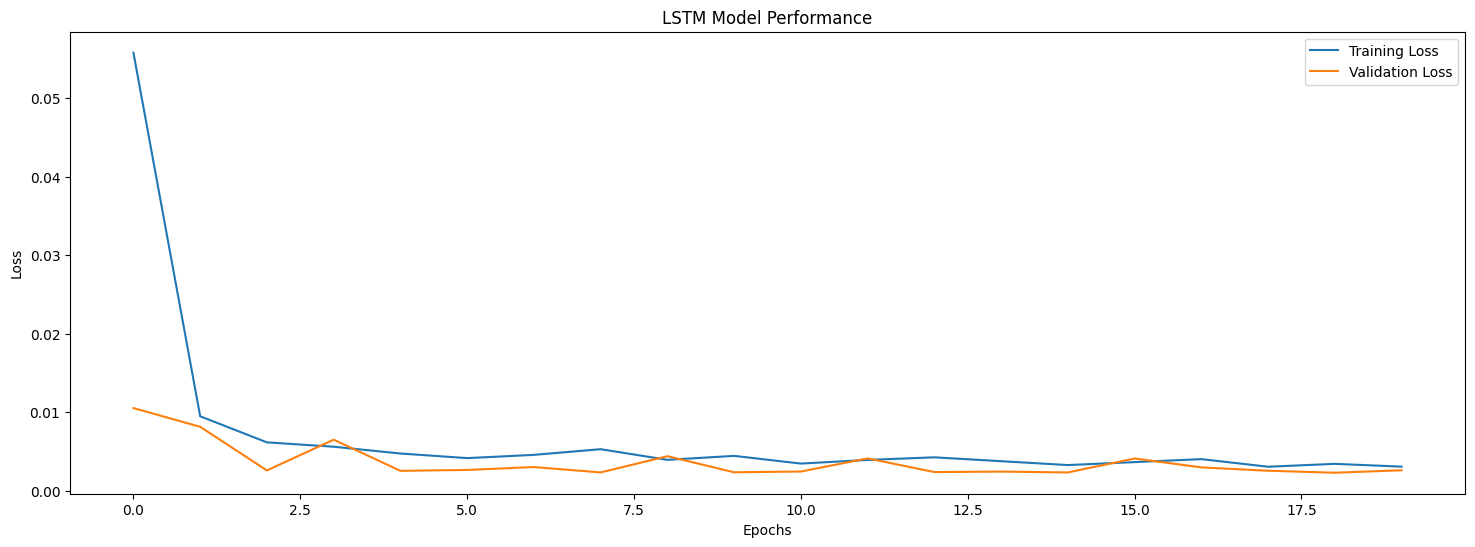

In [67]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


The chart above highlights the following observations:
- Training loss values decrease over the epochs, starting from a higher value and gradually decreasing. This indicates that the model is learning to fit the training data better as training progresses.
- Similarly, the validation loss values also decrease initially, indicating improvement in the model's ability to generalize to unseen data (validation set).
- Some fluctuations in the validation loss have been observed, which is quite justifiable due to the high variations and complexity in the price performance over time.
- There are no signs of overfitting since both loss values are continuously decreasing along with each other over the epochs.
- Validation loss has maintained lower values than training loss across almost the whole training period, which is quite normal due to the complexity/size of training data.

### 6. MODEL INFERENCE

The LSTM model has been trained and evaluated, making it ready to forecast future price trends.

As mentioned earlier, we will employ our model to predict Google stock prices during the testing period. To thoroughly assess the model's performance, we will forecast stock performance for the entire period, including testing samples, and compare these predictions with actual prices.

#### Load Best Model

In [ ]:
# Prepare model location and name
model_location = "/Users/nguyenconghung/Documents/PYTHON/lstm-stock-price-prediction/models/"
model_name = "2303_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

#### Model Prediction

In [69]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Inverse Scaling

One important thing to consider is the scale of the datasets, because the model was trained on scaled data that needs to be transformed back to its original price range.

Therefore, we have to load the same scaler used for transforming the original dataset and apply it to restore the prediction outputs to their actual distribution.

In [ ]:
# Prepare scaler model name and location
scaler_model_location = "/Users/nguyenconghung/Documents/PYTHON/lstm-stock-price-prediction/models/"
scaler_model_name = "2303_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

The scaler was initially fitted on data with 6 columns encompassing all the features considered. However, during the inverse transformation process, our focus is solely on transforming the "Open" price.

To circumvent potential errors triggered by the inverse_transform API, we create a container structure of the necessary shape. We populate the first column with predictions and subsequently disregard the others.

In [71]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

#### Display Predictions

In [72]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

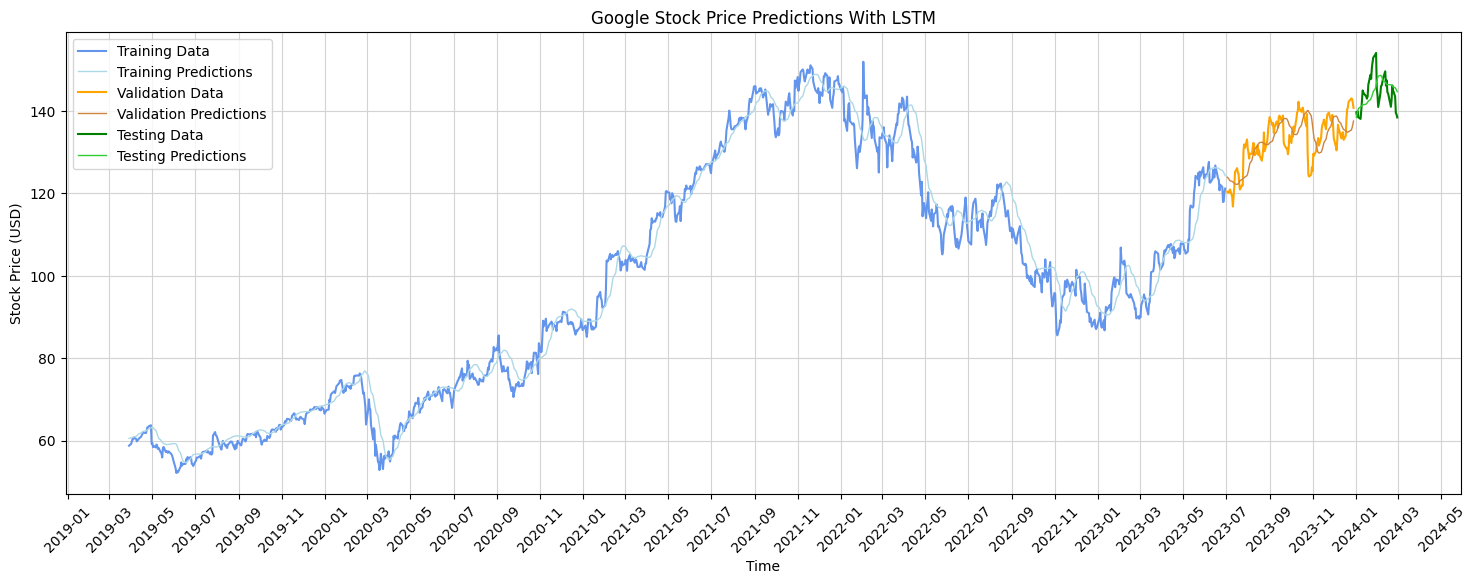

In [ ]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("2303 Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

Based on this expanded overview, the model appears to perform very well throughout the observed period, with the predicted trend tends to align closely with actual stock performance across the three training, validation, and testing periods.

To better assess the model's predictions during the validation and testing periods, let's inspect a zoomed-in version of this chart covering the most recent samples.

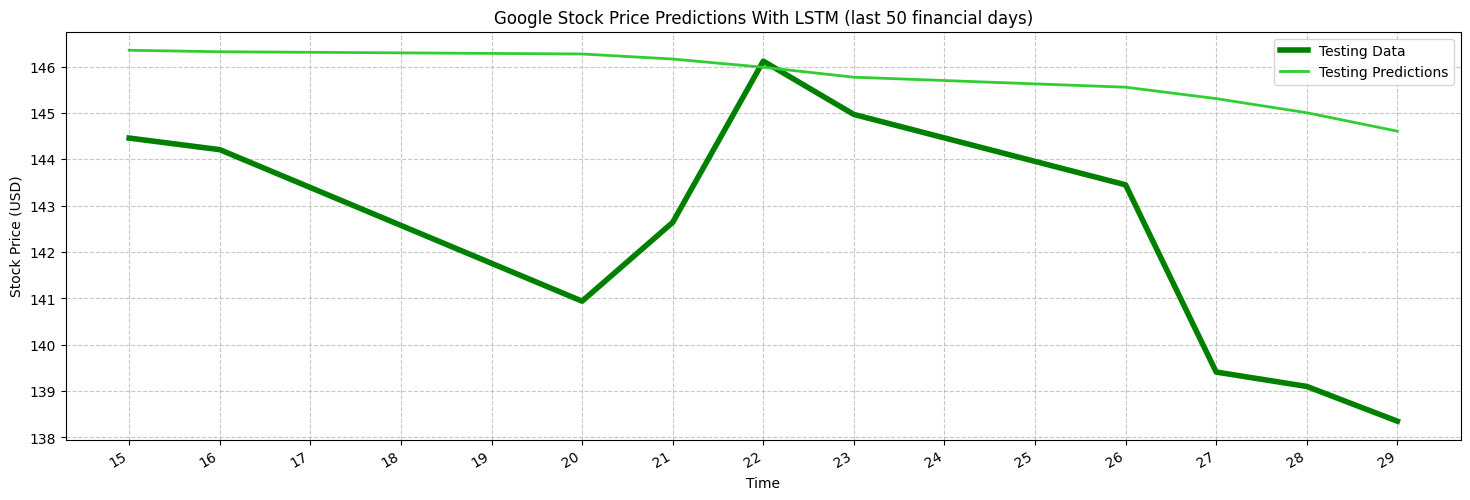

In [ ]:
recent_samples = 10
plt.figure(figsize=(18,6))
# plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
# plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

# plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
# plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates[-10:], y_test_inv[-10:], label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates[-10:], y_test_predict_inv[-10:], label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("2303 Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (TWD)")
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)

# Format X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Date format
plt.gcf().autofmt_xdate()  # Rotate date labels for readability

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

This closer look underscores the great performance of our LSTM model in predicting Google's stock prices during both validation and testing periods. Indicating the ability of this model to generalize on unseen data that was not included in the training set.

Despite the exact value predictions might be slightly different from real prices, the strong performance of this model is primarily derived from its ability to consistently mirror the actual trends across almost all phases. This is the most significant takeaway of stock price predictions analysis.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/z7/f___7hmn2m72m61j8_1qndr40000gn/T/ipykernel_7011/897016097.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  future_input[0, -1, 0] = future_pred  # Assuming the first feature is the target


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

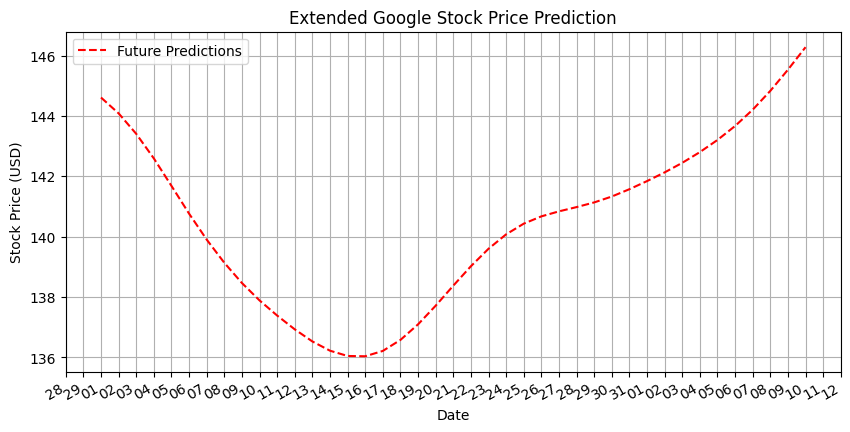

In [ ]:
import datetime

# Define how many days you want to predict into the future
future_days = 41  # Change as needed

# Get the last input sequence
future_input = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

# Generate future dates
last_date = data_test_df["Date"].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# Store predictions
future_predictions = []

for i in range(future_days):
    # Predict the next stock price
    future_pred = best_model.predict(future_input)
    
    # Store the prediction
    future_predictions.append(future_pred[0, 0])
    
    # Update the input sequence (remove the first element, append the new prediction)
    future_input = np.roll(future_input, shift=-1, axis=1)
    future_input[0, -1, 0] = future_pred  # Assuming the first feature is the target

# Convert predictions back to original scale
future_predictions_inv = sc.inverse_transform(
    np.concatenate((np.array(future_predictions).reshape(-1, 1), np.ones((len(future_predictions), 5))), axis=1)
)[:, 0]

# Plot future predictions
plt.figure(figsize=(10,5))
plt.plot(future_dates, future_predictions_inv, label="Future Predictions", color="red", linestyle="dashed")

# plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
# plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)


# Format X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Date format
plt.gcf().autofmt_xdate()  # Rotate date labels for readability


plt.title("Extended 2303 Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price (TWD)")
plt.legend()
plt.grid()
plt.show()
